In [102]:
import sys
import importlib
sys.path.append("C:/Users/joeto/stage/stage_new/final")

import utils
importlib.reload(utils)
from utils import *

import files
importlib.reload(files)
from files import *

In [105]:
"""
Décomposition des données de consommation de chauffage (heat) et de refroidissement (cooling)
pour chaque ville sur une période de 24 heures, en créant des DataFrames séparés pour chaque cas.
ex:consommation_heat_agen
"""

for city, path in files.items():
      globals()[f"consommation_heat_{city}"] = extract_columns(files[city])

for city2, path2 in files.items():
      globals()[f"consommation_cool_{city2}"] = extract_columns(files[city2],5)    

In [108]:
"""
Décomposition du DataFrame de consommation de chauffage à Toulouse  périphérie  en  6h. 
Ajout d'une colonne binaire pour identifier les jours de consommation
Clustering appliqué sur chaque sous-partie avec la possibilité de définir le nombre de clusters pour chaque segment via la liste `n_clusters_list`.  
Les résultats de chaque sous-partie, avec leurs clusters respectifs, sont stockés dans les DataFrames `df_part*`.
"""

df_combined_tou = pd.concat([consommation_heat_agen, consommation_heat_albi,consommation_heat_auch,consommation_heat_toulouse], axis=0).reset_index(drop=True)
df_final_tou=add_binary_column(df_combined_tou, column_name="heat_on")

cols_1 = list(range(0, 6)) + [-1]
cols_2 = list(range(6, 12)) + [-1]  
cols_3 = list(range(12, 17)) + [-1] 
cols_4 = list(range(17, 24)) + [-1]
cols_list = [cols_1, cols_2, cols_3, cols_4]
n_clusters_list = [3, 4, 4, 3]

clustered_dfs = cluster_data(df_combined_tou, 'heat_on', n_clusters_list, cols_list)     
df_part1 = clustered_dfs['df_part1']
df_part2 = clustered_dfs['df_part2'] 
df_part3 = clustered_dfs['df_part3']
df_part4 = clustered_dfs['df_part4']



C:\Users/joeto/stage/stage_new/final\utils.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part.loc[df_part[heat_on_column] == 1, 'clusters'] = model.labels_
C:\Users/joeto/stage/stage_new/final\utils.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part.loc[df_part[heat_on_column] == 1, 'clusters'] = model.labels_
C:\Users/joeto/stage/stage_new/final\utils.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

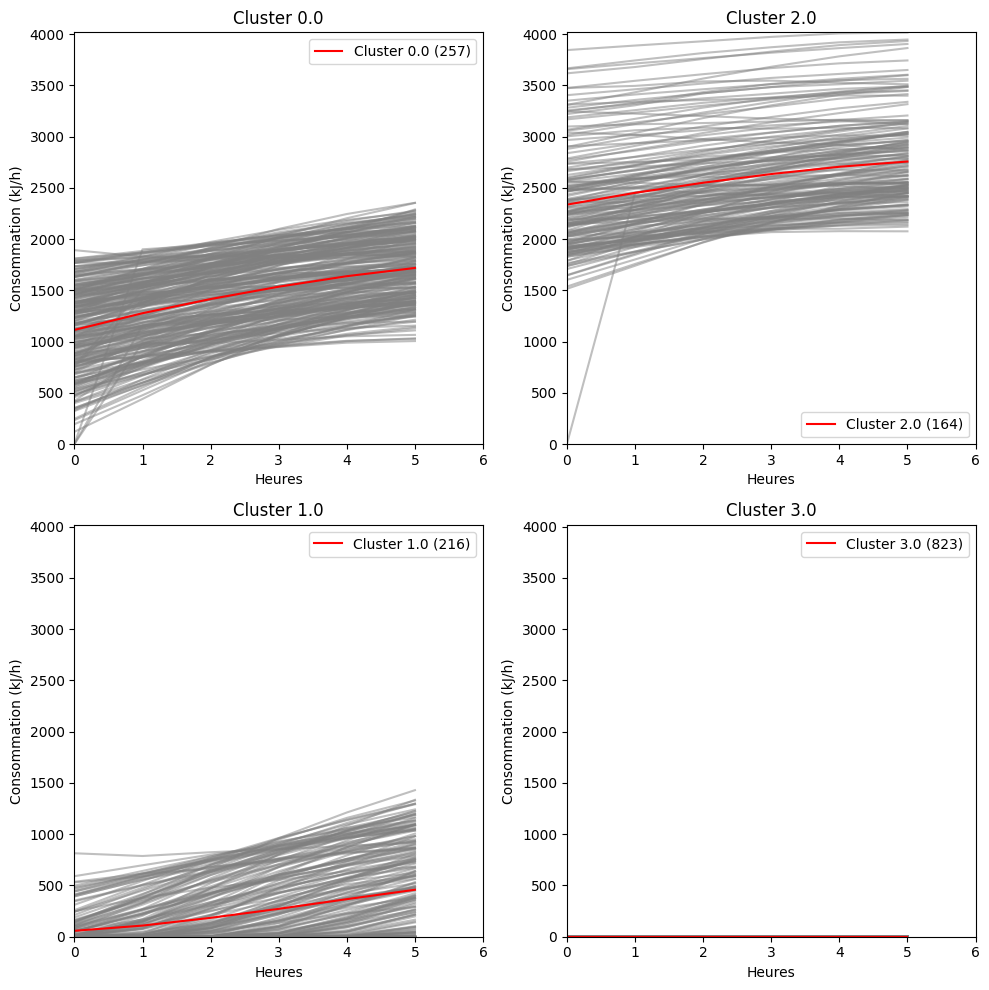

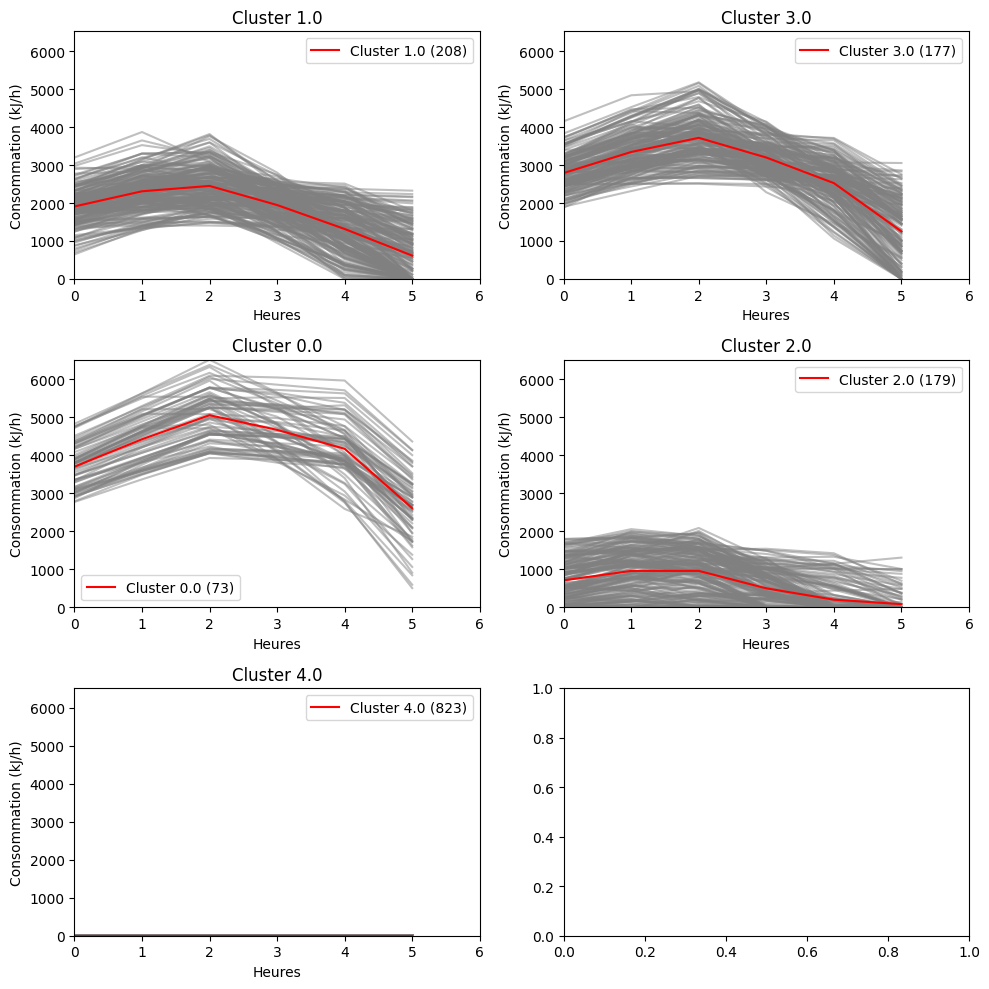

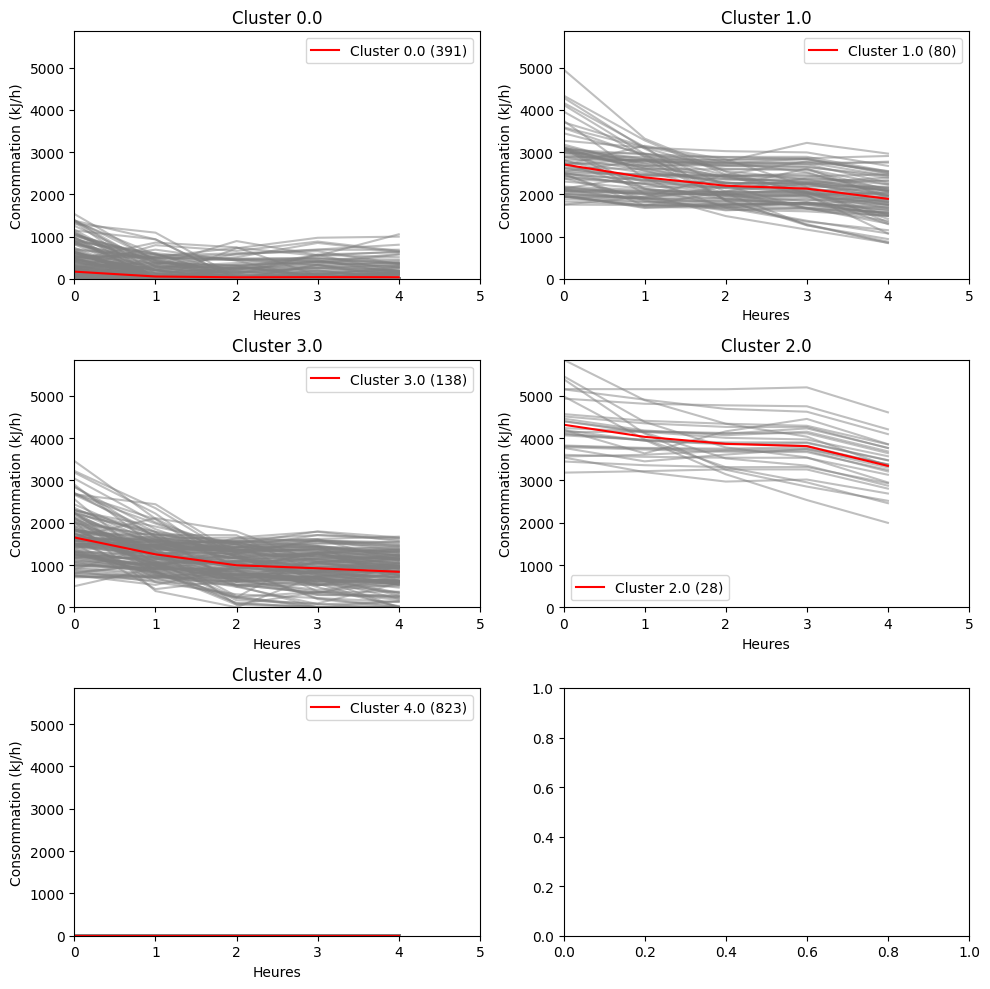

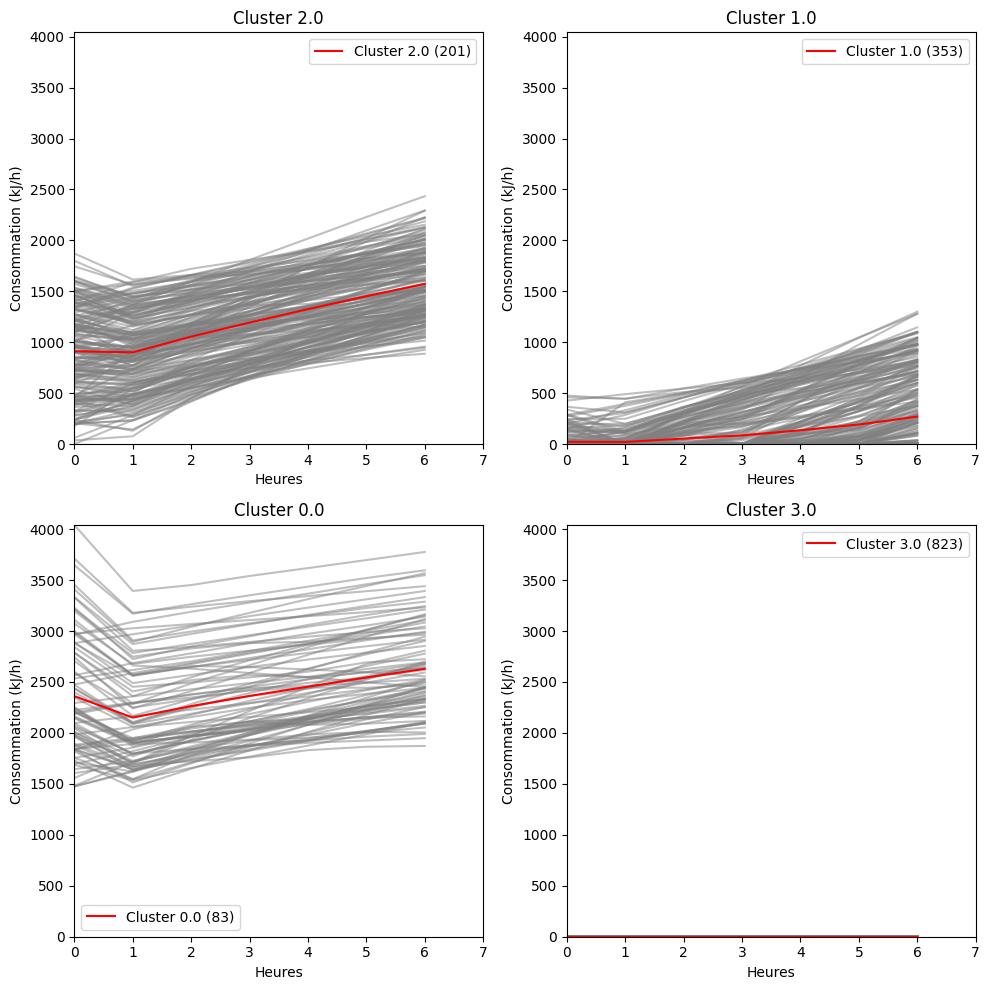

In [109]:
"""
Visualisation de la distribution des séries de consommation pour chaque sous-partie selon les clusters attribués.
"""

plot_clusters(df_part1.drop(columns=["heat_on"]))
plot_clusters(df_part2.drop(columns=["heat_on"]))
plot_clusters(df_part3.drop(columns=["heat_on"]))
plot_clusters(df_part4.drop(columns=["heat_on"]))

In [112]:
"""
Calcul des centres de clusters pour chaque sous-partie, puis évaluation de la qualité du clustering à l’aide des métriques MAE, MSE et RMSE pour chaque cluster.
Les résultats sont ensuite agrégés pour obtenir les performances globales de chaque sous-partie, puis une moyenne générale est calculée.
"""

dfs_parts = {"df_part1": df_part1, "df_part2": df_part2, "df_part3": df_part3, "df_part4": df_part4}
centers_per_part = {part: compute_cluster_centers(df) for part, df in dfs_parts.items()}

def compute_metrics_per_part(df_part):  
    centers_df = compute_cluster_centers(df_part) 
    cluster_centers = centers_df.values 
    metrics = []
    total_samples = len(df_part)

    for cluster_id in df_part["clusters"].unique():
        cluster_data = df_part[df_part["clusters"] == cluster_id].drop(columns=["heat_on", "clusters"])
        cluster_center = centers_df.loc[cluster_id].values
        mse_total, mae_total, rmse_total = 0, 0, 0

        for _, row in cluster_data.iterrows():
            mse, mae, rmse = calculate_metrics(row.values, cluster_center)
            mse_total += mse
            mae_total += mae
            rmse_total += rmse

        num_series = len(cluster_data)

        metrics.append({
            "cluster_id": cluster_id,
            "num_series": num_series,
            "mse": mse_total / num_series,
            "mae": mae_total / num_series,
            "rmse": rmse_total / num_series
        })

    metrics_df = pd.DataFrame(metrics)

    global_metrics = {
        "mse_global": (metrics_df["mse"] * metrics_df["num_series"]).sum() / total_samples,
        "mae_global": (metrics_df["mae"] * metrics_df["num_series"]).sum() / total_samples,
        "rmse_global": (metrics_df["rmse"] * metrics_df["num_series"]).sum() / total_samples
    }

    return metrics_df, global_metrics

metrics_results = {part: compute_metrics_per_part(df) for part, df in dfs_parts.items()}

all_metrics_dfs = {part: metrics_df for part, (metrics_df, _) in metrics_results.items()}
all_global_metrics = {part: global_metrics for part, (_, global_metrics) in metrics_results.items()}

for part, metrics_df in all_metrics_dfs.items():
    print(f"\nMétriques pour chaque cluster dans la partition {part}:")
    print(metrics_df)

global_metrics_combined = pd.DataFrame(all_global_metrics).T  
avg_metrics = global_metrics_combined[['mse_global', 'mae_global', 'rmse_global']].mean()

print("\nMétriques globales par partition:")
print(global_metrics_combined)  
print("\nMoyennes des métriques globales sur toutes les partitions:")
print(avg_metrics)  




Métriques pour chaque cluster dans la partition df_part1:
   cluster_id  num_series            mse         mae        rmse
0         0.0         257  116974.996981  290.508448  305.029442
1         2.0         164  212724.069646  366.543119  378.020604
2         1.0         216   96779.626387  248.835302  280.034901
3         3.0         823       0.000000    0.000000    0.000000

Métriques pour chaque cluster dans la partition df_part2:
   cluster_id  num_series            mse         mae        rmse
0         1.0         208  285593.380010  432.958246  508.157160
1         3.0         177  344791.944728  471.354782  553.767174
2         0.0          73  456425.439417  554.234283  629.070399
3         2.0         179  230576.338013  383.457406  453.233190
4         4.0         823       0.000000    0.000000    0.000000

Métriques pour chaque cluster dans la partition df_part3:
   cluster_id  num_series            mse         mae        rmse
0         0.0         391   38763.588397  1

In [113]:
"""
Combinaison des sous-parties pour former une journée complète de 24 heures. 
Chaque sous-partie est associée à une colonne de cluster. 
Il y a ainsi 4 colonnes de clusters au total
"""

clusters = [
    df_part1.iloc[:, -1], 
    df_part2.iloc[:, -1], 
    df_part3.iloc[:, -1], 
    df_part4.iloc[:, -1]
]

combined_rows = []
n_rows = df_part1.shape[0]

for i in range(n_rows):
    data_parts = [
        df_part1.iloc[i, :-2], 
        df_part2.iloc[i, :-2], 
        df_part3.iloc[i, :-2], 
        df_part4.iloc[i, :-2]
    ]
    sum_last_col = (
        df_part1.iloc[i, -2] + 
        df_part2.iloc[i, -2] + 
        df_part3.iloc[i, -2] + 
        df_part4.iloc[i, -2]
    )
    sum_status = 1.0 if sum_last_col != 0 else 0.0
    combined_row = pd.concat(data_parts, axis=0).reset_index(drop=True)

    combined_row = pd.concat([combined_row, pd.Series(sum_status, index=["heat_on"])], axis=0)
    for j in range(4):
        combined_row[f'cluster_{j+1}'] = clusters[j].iloc[i]
    combined_rows.append(combined_row)

final_combined_df = pd.DataFrame(combined_rows)

In [114]:
final_combined_df.to_csv("../data/simulation_data/conso_kmeans_data/clusters_heat_perif_toulouse_parts_6h_combined_kmeans",index=False)

In [121]:
"""
Modification des 4 parties pour ajouter, à chaque segment de 6 heures, les 6 heures précédentes. 
pour effectuer des prédictions basées sur les 6 heures actuelles et les 6 heures passées
Chaque partie peut être accédée individuellement via `new_parts['new_part1']`, `new_parts['new_part2']`, etc.
"""

new_parts = {}
n_rows = df_part1.shape[0]
for i in range(1,n_rows):
    new_parts_row = {}  
    old_parts = [df_part1, df_part2, df_part3, df_part4]
    prev_parts = [df_part4, df_part1, df_part2, df_part3]  
    for j in range(4): 
        df_current = old_parts[j] 
        df_prev = prev_parts[j] 
        current_hours = df_current.iloc[i, :-2]  
        if j == 0:  
            prev_hours = df_prev.iloc[i-1, :-2]            
        else:
            prev_hours = df_prev.iloc[i, :-2]        
        combined_hours = pd.concat([prev_hours, current_hours], axis=0).reset_index(drop=True)
        heat_on = df_current.iloc[i, -2]  
        cluster = df_current.iloc[i, -1]   
        new_row = pd.concat([combined_hours, pd.Series([heat_on, cluster], index=['heat_on', 'cluster'])])
        new_parts_row[f'new_part{j+1}'] = new_row
    for key in new_parts_row:
        if key not in new_parts:
            new_parts[key] = []
        new_parts[key].append(new_parts_row[key])
for key in new_parts:
    new_parts[key] = pd.DataFrame(new_parts[key]).reset_index(drop=True)




In [120]:
for i in range(1, 5): 
    new_part_name = f'new_part{i}' 
    file_name = f'consommation_partitionner_48h_{i}.csv' 
    new_parts[new_part_name].to_csv(file_name, index=False)

old_parts = [df_part1, df_part2, df_part3, df_part4]
for i in range(4):  
    file_name = f'consommation_partitionner_24h_{i+1}.csv' 
    old_parts[i].to_csv(file_name, index=False)

                0            1            2            3            4  \
0      438.092729   443.563006   550.901415   646.370512   743.109752   
1     1494.268446  1326.179027  1410.426252  1484.021184  1554.364636   
2     1157.571426  1092.453568  1181.637932  1266.377242  1360.725885   
3     1325.654957  1220.437660  1369.680898  1507.258916  1641.319652   
4        0.000000     0.000000     0.000000     0.000000    46.955345   
...           ...          ...          ...          ...          ...   
1454  2472.223257  2096.065707  2282.243051  2452.743731  2623.332884   
1455  1967.041487  1637.559708  1830.489975  2005.155298  2161.124934   
1456  1877.499470  1635.163966  1740.933433  1837.902088  1928.618153   
1457   651.348034   882.534736  1017.304426  1132.219242  1241.276953   
1458  1501.334358  1595.491409  1645.752598  1664.723577  1712.786774   

                5            6            7            8            9  \
0      835.762224   925.102476  1023.735651  1144.